In [1]:
import pandas as pd
import xarray as xr


argo_prof='/swot/SUM01/spencer/Argo_test/5904468_Mprof.nc'
argo_prof2='/swot/SUM01/spencer/Argo_test/5904471_Mprof.nc'
prof1=xr.open_dataset(argo_prof)
prof2=xr.open_dataset(argo_prof2)

In [2]:
prof2

<xarray.Dataset>
Dimensions:                          (N_CALIB: 1, N_HISTORY: 0, N_LEVELS: 500, N_PARAM: 6, N_PROF: 402)
Dimensions without coordinates: N_CALIB, N_HISTORY, N_LEVELS, N_PARAM, N_PROF
Data variables:
    DATA_TYPE                        object ...
    FORMAT_VERSION                   object ...
    HANDBOOK_VERSION                 object ...
    REFERENCE_DATE_TIME              object ...
    DATE_CREATION                    object ...
    DATE_UPDATE                      object ...
    PLATFORM_NUMBER                  (N_PROF) object ...
    PROJECT_NAME                     (N_PROF) object ...
    PI_NAME                          (N_PROF) object ...
    STATION_PARAMETERS               (N_PROF, N_PARAM) object ...
    CYCLE_NUMBER                     (N_PROF) float64 ...
    DIRECTION                        (N_PROF) object ...
    DATA_CENTRE                      (N_PROF) object ...
    DC_REFERENCE                     (N_PROF) object ...
    DATA_STATE_INDICATOR       

In [3]:
ds=prof2
from scipy.signal import medfilt
import matplotlib.pyplot as plt
import numpy as np
import gsw
def maval(a,b):
    return np.ma.masked_values(a,b)
lat = ds.LATITUDE
lon = ds.LONGITUDE
p = ds.PRES_ADJUSTED.where(xr.DataArray(maval(maval(maval(maval(maval(np.asarray(ds.PRES_ADJUSTED_QC,dtype=float),
                                                                     0.),3.),4.),6.),7.), 
                                        dims=ds.PRES_ADJUSTED_QC.dims, coords=ds.PRES_ADJUSTED_QC.coords)<9.)
p = np.ma.masked_invalid(p.where(p!=99999.).where(p>0.))
maskp = p.mask
            
t = ds.TEMP_ADJUSTED.where(xr.DataArray(maval(maval(maval(maval(maval(np.asarray(ds.TEMP_ADJUSTED_QC,dtype=float),
                                                                     0.),3.),4.),6.),7.), 
                                        dims=ds.TEMP_ADJUSTED_QC.dims, coords=ds.TEMP_ADJUSTED_QC.coords)<9.)
t = t.where(t!=99999.)
s = ds.PSAL_ADJUSTED.where(xr.DataArray(maval(maval(maval(maval(maval(np.asarray(ds.PSAL_ADJUSTED_QC,dtype=float),
                                                                     0.),3.),4.),6.),7.), 
                                        dims=ds.PSAL_ADJUSTED_QC.dims, coords=ds.PSAL_ADJUSTED_QC.coords)<9.)
s = s.where(s!=99999.).where(s>0.)
SA = xr.apply_ufunc(gsw.SA_from_SP,s,p,lon,lat)
pt = xr.apply_ufunc(gsw.pt0_from_t,SA,t,p)
CT = xr.apply_ufunc(gsw.CT_from_pt,SA,pt)
rho = np.ma.masked_invalid(xr.apply_ufunc(gsw.rho,SA,CT,0))
maskr = rho.mask


doxy = ds.DOXY_ADJUSTED.where(xr.DataArray(maval(maval(maval(maval(maval(np.asarray(ds.DOXY_ADJUSTED_QC,dtype=float),
                                                                        0.),3.),4.),6.),7.), 
                                        dims=ds.DOXY_ADJUSTED_QC.dims, coords=ds.DOXY_ADJUSTED_QC.coords)<9.
                              ).where(ds.DOXY_ADJUSTED!=99999.)
depth=xr.apply_ufunc(gsw.z_from_p,p,xr.ones_like(ds.PRES_ADJUSTED)*lat)

In [4]:
new_dataset=ds[['LATITUDE', 'LONGITUDE','PRES']]
new_dataset=xr.merge([new_dataset,depth.to_dataset(name='depth')])
new_dataset=xr.merge([new_dataset,pt.to_dataset(name='pt')])
new_dataset=xr.merge([new_dataset,SA.to_dataset(name='SA')])
new_dataset

<xarray.Dataset>
Dimensions:    (N_LEVELS: 500, N_PROF: 402)
Dimensions without coordinates: N_LEVELS, N_PROF
Data variables:
    LATITUDE   (N_PROF) float64 ...
    LONGITUDE  (N_PROF) float64 ...
    PRES       (N_PROF, N_LEVELS) float32 ...
    depth      (N_PROF, N_LEVELS) float64 -2.376 -3.96 -5.94 ... nan nan nan
    pt         (N_PROF, N_LEVELS) float64 -1.734 -1.733 -1.735 ... nan nan nan
    SA         (N_PROF, N_LEVELS) float64 34.02 34.02 34.02 ... nan nan nan

In [41]:
#load MITgcm levels
import xmitgcm
datadir='/swot/SUM01/spencer/1D'
iters=[1460]
prefixes=['diag_state']
ds1D=xmitgcm.open_mdsdataset(datadir,prefix=prefixes)

In [42]:
ds1D

<xarray.Dataset>
Dimensions:  (XC: 1, XG: 1, YC: 1, YG: 1, Z: 42, Zl: 42, Zp1: 43, Zu: 42, time: 37)
Coordinates:
  * XC       (XC) >f4 3.0
  * YC       (YC) >f4 -65.5
  * XG       (XG) >f4 0.0
  * YG       (YG) >f4 -67.0
  * Z        (Z) >f4 -2.1 -6.7 -12.15 -18.55 ... -1300.0 -1400.0 -1500.0 -1600.0
  * Zp1      (Zp1) >f4 0.0 -4.2 -9.2 -15.1 ... -1350.0 -1450.0 -1550.0 -1650.0
  * Zu       (Zu) >f4 -4.2 -9.2 -15.1 -22.0 ... -1350.0 -1450.0 -1550.0 -1650.0
  * Zl       (Zl) >f4 0.0 -4.2 -9.2 -15.1 ... -1250.0 -1350.0 -1450.0 -1550.0
    rA       (YC, XC) >f4 dask.array<shape=(1, 1), chunksize=(1, 1)>
    dxG      (YG, XC) >f4 dask.array<shape=(1, 1), chunksize=(1, 1)>
    dyG      (YC, XG) >f4 dask.array<shape=(1, 1), chunksize=(1, 1)>
    Depth    (YC, XC) >f4 dask.array<shape=(1, 1), chunksize=(1, 1)>
    rAz      (YG, XG) >f4 dask.array<shape=(1, 1), chunksize=(1, 1)>
    dxC      (YC, XG) >f4 dask.array<shape=(1, 1), chunksize=(1, 1)>
    dyC      (YG, XC) >f4 dask.array<shape=(1,

In [6]:
#move to pandas and interpolate onto useful depth levels
pandas_dataset=new_dataset.to_dataframe()
dateset=ds[['JULD']].to_dataframe()
pandas_dataset['depth']=-pandas_dataset['depth']
pandas_dataset=pandas_dataset.reset_index().dropna(subset=['depth']).set_index(['N_PROF','depth']).drop(['N_LEVELS'],axis=1)
for i in range(0,402):
    exists=(pandas_dataset.index.get_level_values('N_PROF').values == i).any()
    if exists:
        to_interp=pandas_dataset.xs(i,level='N_PROF')
        to_interp=to_interp.reindex(list(to_interp.index) + list(-ds1D.Z.values))
        to_interp=to_interp.sort_index().interpolate()
        sLength = len(to_interp.index)
        to_interp = to_interp.assign(N_PROF=np.ones(sLength)*i)
        to_interp['depth']=to_interp.index
        if i==0:
            interped=to_interp.loc[-ds1D.Z.values]
        else:
            interped=interped.merge(to_interp.loc[-ds1D.Z.values],how='outer')
interped=interped.merge(dateset.reset_index(),how='outer')

/home/spencerj/.conda/envs/pangeo1/lib/python3.6/site-packages/ipykernel/__main__.py:18: FutureWarning: 'depth' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


In [7]:
import datetime
depthset=interped[['depth']]
depthset=depthset.dropna().drop_duplicates()
depthset['iDEPTH']=depthset.index
interpedi=interped.merge(depthset,how='left')
interpedi=interpedi.set_index(['N_PROF','iDEPTH'])
interpedi.index.names = ['iPROF','iDEPTH']

#deal with time values
interpedi['JULD']=pd.to_datetime(interpedi['JULD'])#.astype('datetime64[Y]')
interpedi['hour'],interpedi['minute'],interpedi['second']=interpedi['JULD'].dt.hour,interpedi['JULD'].dt.minute,interpedi['JULD'].dt.second
interpedi['year'], interpedi['month'], interpedi['day'] = interpedi['JULD'].dt.year, interpedi['JULD'].dt.month,interpedi['JULD'].dt.day
interpedi['date']=(interpedi['year'].astype(str).str.zfill(4)+interpedi['month'].astype(str).str.zfill(2)+interpedi['day'].astype(str).str.zfill(2)).astype('f8')
interpedi=interpedi.drop(['year','month','day','PRES'], axis=1)
interpedi['time']=(interpedi['hour'].astype(str).str.zfill(2)+interpedi['minute'].astype(str).str.zfill(2)+interpedi['second'].astype(str).str.zfill(2)).astype('f8')
interpedi['JULD']=interpedi['JULD'].dt.strftime("%d-%b-%Y %H:%M:%S")
interpedi=interpedi.drop(['hour','minute','second'], axis=1)


#rename so you can merge with stolen weights
interpedi=interpedi.rename(index=float, columns={"depth": "prof_depth"})
interpedi1= interpedi.reset_index()
interpedi=interpedi1[interpedi1['iDEPTH'].astype('f8').notnull()]
interpedi=interpedi[interpedi['LATITUDE'].astype('f8').notnull()]
interpedi=interpedi[interpedi['LONGITUDE'].astype('f8').notnull()]


In [8]:
#steal weights
argo_test='/swot/SUM01/spencer/Argo_test/argo_2015_feb2016_llc90_step_09_20160308.nc'
prof_ecco=xr.open_dataset(argo_test)
pandas_ecco=prof_ecco[['prof_lat','prof_lon','prof_Tweight','prof_Sweight','prof_depth']].to_dataframe()
pandas_ecco=(pandas_ecco[pandas_ecco.prof_lat<-63])[pandas_ecco.prof_lat>-67][pandas_ecco.prof_lon>0][pandas_ecco.prof_lon<6]
pandas_Tweight=pandas_ecco[pandas_ecco.prof_Tweight>0].groupby('prof_depth').mean()['prof_Tweight']
pandas_Sweight=pandas_ecco[pandas_ecco.prof_Sweight>0].groupby('prof_depth').mean()['prof_Sweight']
pandas_Tweight=pandas_Tweight.reindex(list(pandas_Tweight.index) + list(-ds1D.Z.values))
pandas_Sweight=pandas_Sweight.reindex(list(pandas_Sweight.index) + list(-ds1D.Z.values))
pandas_Tweight=pandas_Tweight.sort_index().interpolate()
pandas_Sweight=pandas_Sweight.sort_index().interpolate()
pandas_Tweight.iloc[0]=pandas_Tweight.iloc[1]
pandas_Sweight.iloc[0]=pandas_Sweight.iloc[1]
pandas_Tweight=pandas_Tweight[pandas_Tweight.index.isin(-ds1D.Z.values)].drop_duplicates()
pandas_Sweight=pandas_Sweight[pandas_Sweight.index.isin(-ds1D.Z.values)].drop_duplicates()


/home/spencerj/.conda/envs/pangeo1/lib/python3.6/site-packages/ipykernel/__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [10]:
from scipy.io import loadmat
x = loadmat('/swot/SUM01/spencer/bsose_bits/sose_bgc_stats_smooth.mat')
grid_matt=xr.open_dataset('/swot/SUM01/spencer/bsose_bits/grid_full.nc')
err02=x['errO2']
mean_errO2=np.mean(np.mean(err02[0:18,113:135,:],axis=0),axis=0)
O2weight_interp=(np.interp(-ds1D.Z.values,-grid_matt.RC.values,mean_errO2)).astype('>f')
#plt.plot(-grid_matt.RC.values,mean_errO2)
#plt.plot(-ds1D.Z.values,O2weight_interp,'x')
pandas_Oweight=pd.Series(O2weight_interp,index=pandas_Tweight.index)

In [11]:
interped_weight=interpedi.reset_index().merge(pandas_Tweight.reset_index(),how='left',on='prof_depth')
interped_weight=interped_weight.merge(pandas_Sweight.reset_index(),how='left',on='prof_depth')
interped_weight=interped_weight.set_index(['iPROF','iDEPTH'])
interped_weight=interped_weight[interped_weight['prof_Tweight'].astype('f8').notnull()]
interped_weight=interped_weight[interped_weight['prof_Sweight'].astype('f8').notnull()]

In [12]:
# convert to xarray and rename variables
interpedx=interped_weight.to_xarray()
interpedx=interpedx.rename({'LATITUDE':'prof_lat','LONGITUDE':'prof_lon','pt':'prof_T',
                            'SA':'prof_S','date':'prof_YYYYMMDD','time':'prof_HHMMSS','JULD':'prof_date'})
interpedx['prof_Tflag']=interpedx['prof_T'].where(np.isnan(interpedx['prof_T']), other=0, drop=False)
interpedx['prof_Tflag']=interpedx['prof_Tflag'].where(interpedx['prof_Tflag']==0, other=1, drop=False)
interpedx['prof_Sflag']=interpedx['prof_S'].where(np.isnan(interpedx['prof_S']), other=0, drop=False)
interpedx['prof_Sflag']=interpedx['prof_Sflag'].where(interpedx['prof_Sflag']==0, other=1, drop=False)
interpedx['prof_descr']=interpedx['iPROF'].astype(str)

interpedx['prof_T']=interpedx['prof_T'].where(np.isfinite(interpedx['prof_T']), other=0, drop=False)
interpedx['prof_S']=interpedx['prof_S'].where(np.isfinite(interpedx['prof_S']), other=0, drop=False)

interpedx['prof_YYYYMMDD']=interpedx.prof_YYYYMMDD[:,8]
interpedx['prof_HHMMSS']=interpedx.prof_HHMMSS[:,8]
interpedx['prof_lon']=interpedx.prof_lon[:,8]
interpedx['prof_lat']=interpedx.prof_lat[:,8]
interpedx['prof_depth']=interpedx.prof_depth[:,8]
interpedx=interpedx.drop(['iDEPTH','iPROF','index'])
interpedx['prof_Tweight']=interpedx['prof_Tweight'].where(interpedx['prof_Tweight'].notnull(),0.001)
interpedx['prof_Sweight']=interpedx['prof_Sweight'].where(interpedx['prof_Sweight'].notnull(),0.001)
interpedx.to_netcdf('test_argo.nc')

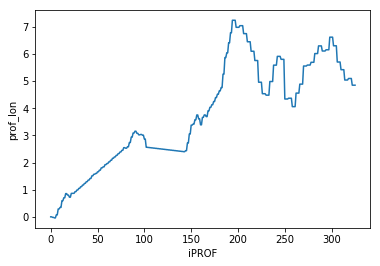

In [40]:
interpedx['prof_lon'].plot()

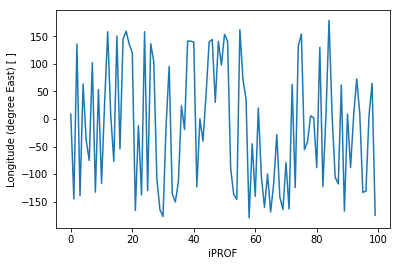

In [39]:
argo_test='/swot/SUM01/spencer/Argo_test/argo_2015_feb2016_llc90_step_09_20160308.nc'
prof_ecco=xr.open_dataset(argo_test)
prof_ecco.prof_lon[0:100].plot()

In [18]:
pandas_Tweight

prof_depth
2.100000        0.483216
6.700000        0.500189
12.150000       0.517163
18.549999       0.578588
26.250000       0.656796
35.250000       0.609254
45.000000       0.527955
55.000000       0.430813
65.000000       0.299081
75.000000       0.272233
85.000000       0.267368
95.000000       0.291203
105.000000      0.291742
115.000000      0.351294
125.000000      0.483318
135.000000      0.663487
146.500000      1.120743
161.500000      1.438772
180.000000      1.967747
200.000000      2.460358
220.000000      3.066332
240.000000      3.748401
260.000000      4.609740
280.000000      5.014430
301.000000      5.713635
327.000000      6.312647
361.000000      7.634455
402.500000      9.030281
450.000000      9.686204
500.000000     10.471743
551.500000     12.208255
614.000000     13.779308
700.000000     14.739701
800.000000     16.786930
900.000000     19.135674
1000.000000    20.167812
1100.000000    20.059293
1200.000000    20.067709
1300.000000    20.214410
1400.000000   